#Model 1

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


df = pd.read_csv('DataFile_ML_All.csv')


df = df.drop(columns=['Date', 'id', 'station_code'])

# Select the features and target variable
selected_features = ['Secchi Depth(m)', 'DO(mg/l)', 'Temperature (deg cels)', 'Salinity(ppt)','pH', 'Turbidity(NTU)', 'Nitrate+Nitrite']

X = df[selected_features]  # Independent variables
y = df['Chlorophyll-a (ug/l)']           # Target variable

# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Random Forest Regression Model

In [24]:
#Bayesian Optimization

In [25]:
# Bayesian Optimization
from skopt import gp_minimize

def objective_function(params):
    # Here, params is a list of hyperparameters to optimize
    n_estimators, max_depth, min_samples_split, min_samples_leaf = params

    # Train a model with the given hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Calculate the MAE as the metric to minimize
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)

    return mae  # We want to minimize MAE

from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Define the search space for hyperparameters
space = [
    Integer(1, 200, name='n_estimators'),
    Integer(1, 30, name='max_depth'),
    Integer(2, 10, name='min_samples_split'),
    Integer(1, 10, name='min_samples_leaf')
]

# Perform Bayesian optimization to minimize MAE
result = gp_minimize(objective_function, space, n_calls=10, random_state=42)

# The result variable will contain the optimal hyperparameters that minimize MAE
optimal_hyperparameters = result.x
optimal_mae = result.fun

# Print all hyperparameters and their values
for param, value in zip(space, optimal_hyperparameters):
    print(f"Hyperparameter {param.name}: {value}")
print("Optimal MAE:", optimal_mae)

Hyperparameter n_estimators: 160
Hyperparameter max_depth: 6
Hyperparameter min_samples_split: 8
Hyperparameter min_samples_leaf: 6
Optimal MAE: 2.550975172266328


In [26]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100
decision_trees_mean = []

for iteration in range(num_iterations):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    # Train the decision model (Random Forest Regressor) using Dj as the training data
    rf_model_HAB_Bayesian_01 = RandomForestRegressor(
        random_state=42, 
        n_estimators=160, 
        max_depth=6, 
        min_samples_split=8, 
        min_samples_leaf=6
    )
    rf_model_HAB_Bayesian_01.fit(X_train_bootstrap, y_train_bootstrap)

    # Append the trained decision tree to the respective list
    decision_trees_mean.append(rf_model_HAB_Bayesian_01) 

    # Step 3: Predictions and Combining Decision Trees
    # Predictions
    predictions_mean_train = [tree.predict(X_train) for tree in decision_trees_mean]
    combined_predictions_mean_train = np.mean(predictions_mean_train, axis=0)

    predictions_mean_test = [tree.predict(X_test) for tree in decision_trees_mean]
    combined_predictions_mean_test = np.mean(predictions_mean_test, axis=0)

    # Step 4: Evaluate the Model

    # Calculate performance metrics for the current iteration
    r2_mean_train = r2_score(y_train, combined_predictions_mean_train)
    r2_mean_test = r2_score(y_test, combined_predictions_mean_test)
    mse_mean_train = mean_squared_error(y_train, combined_predictions_mean_train)
    mse_mean_test = mean_squared_error(y_test, combined_predictions_mean_test)
    rmse_mean_train = np.sqrt(mse_mean_train)
    rmse_mean_test = np.sqrt(mse_mean_test)
    mae_mean_train = mean_absolute_error(y_train, combined_predictions_mean_train)
    mae_mean_test = mean_absolute_error(y_test, combined_predictions_mean_test)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - combined_predictions_mean_train) / y_train).mean() * 100
    pbias_test = ((y_test - combined_predictions_mean_test) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_mean_train)
    test_r2_values.append(r2_mean_test)
    train_mse_values.append(mse_mean_train)
    test_mse_values.append(mse_mean_test)
    train_rmse_values.append(rmse_mean_train)
    test_rmse_values.append(rmse_mean_test)
    train_mae_values.append(mae_mean_train)
    test_mae_values.append(mae_mean_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.6306913496405255
Average Test R2: 0.5175358884190149
Average Train MSE: 9.94307340129145
Average Test MSE: 12.498759240378954
Average Train RMSE: 3.15303766596153
Average Test RMSE: 3.5352412116032337
Average Train MAE: 2.136975441537297
Average Test MAE: 2.5440825517503596
Average Train PBIAS: -46.96997400351619
Average Test PBIAS: -49.03804738273848


In [27]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('rf_model_HAB_Bayesian_01.pkl', 'wb') as file:
    pickle.dump(rf_model_HAB_Bayesian_01, file)
    
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(rf_model_HAB_Bayesian_01, 'rf_model_HAB_Bayesian_01.joblib')

['rf_model_HAB_Bayesian_01.joblib']

In [28]:
#Grid Search Optimization

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

# Define the hyperparameter space
param_grid = {
    'n_estimators': [1, 200],
    'max_depth': [4,6,8, 10],
    'min_samples_split': [7, 8, 9],
    'min_samples_leaf': [4, 6, 8, 10]
}

# Create the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Define MAE as a scorer
mae_scorer = make_scorer(mean_absolute_error)

# Perform grid search with MAE scoring
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5, scoring=mae_scorer, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Print the best parameters and MAE
best_params = grid_search.best_params_
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"MAE: {mae}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters:
max_depth: 10
min_samples_leaf: 4
min_samples_split: 7
n_estimators: 1
MAE: 3.226114154413394


In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100
decision_trees_mean = []

for iteration in range(num_iterations):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    # Train the decision model (Random Forest Regressor) using Dj as the training data
    rf_model_HAB_Grid_01 = RandomForestRegressor(
        random_state=42, 
        max_depth= 10,
        min_samples_leaf= 4,
        min_samples_split= 7,
        n_estimators= 1
    )
    rf_model_HAB_Grid_01.fit(X_train_bootstrap, y_train_bootstrap)

    # Append the trained decision tree to the respective list
    decision_trees_mean.append(rf_model_HAB_Grid_01) 

    # Step 3: Predictions and Combining Decision Trees
    # Predictions
    predictions_mean_train = [tree.predict(X_train) for tree in decision_trees_mean]
    combined_predictions_mean_train = np.mean(predictions_mean_train, axis=0)

    predictions_mean_test = [tree.predict(X_test) for tree in decision_trees_mean]
    combined_predictions_mean_test = np.mean(predictions_mean_test, axis=0)

 

    # Calculate performance metrics for the current iteration
    r2_mean_train = r2_score(y_train, combined_predictions_mean_train)
    r2_mean_test = r2_score(y_test, combined_predictions_mean_test)
    mse_mean_train = mean_squared_error(y_train, combined_predictions_mean_train)
    mse_mean_test = mean_squared_error(y_test, combined_predictions_mean_test)
    rmse_mean_train = np.sqrt(mse_mean_train)
    rmse_mean_test = np.sqrt(mse_mean_test)
    mae_mean_train = mean_absolute_error(y_train, combined_predictions_mean_train)
    mae_mean_test = mean_absolute_error(y_test, combined_predictions_mean_test)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - combined_predictions_mean_train) / y_train).mean() * 100
    pbias_test = ((y_test - combined_predictions_mean_test) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_mean_train)
    test_r2_values.append(r2_mean_test)
    train_mse_values.append(mse_mean_train)
    test_mse_values.append(mse_mean_test)
    train_rmse_values.append(rmse_mean_train)
    test_rmse_values.append(rmse_mean_test)
    train_mae_values.append(mae_mean_train)
    test_mae_values.append(mae_mean_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.7128892265015275
Average Test R2: 0.522146482832131
Average Train MSE: 7.730020654588324
Average Test MSE: 12.379316761360691
Average Train RMSE: 2.774641479010615
Average Test RMSE: 3.5113454444461856
Average Train MAE: 1.8341858600991485
Average Test MAE: 2.561171496553456
Average Train PBIAS: -38.91440265424564
Average Test PBIAS: -47.6153128133016


In [32]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('rf_model_HAB_Grid_01.pkl', 'wb') as file:
    pickle.dump(rf_model_HAB_Grid_01, file)
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(rf_model_HAB_Grid_01, 'rf_model_HAB_Grid_01.joblib')

['rf_model_HAB_Grid_01.joblib']

In [ ]:
#randomized search optimization

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

# Define the hyperparameter space
param_dist = {
    'n_estimators': [1, 200],
    'max_depth': [4,6,8, 10],
    'min_samples_split': [7, 8, 9],
    'min_samples_leaf': [4, 6, 8, 10]
}

# Create the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Define MAE as a scorer
mae_scorer = make_scorer(mean_absolute_error)

# Perform randomized search with MAE scoring
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=100, cv=5, scoring=mae_scorer, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Print the best parameters and MAE
best_params = random_search.best_params_
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"MAE: {mae}")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters:
n_estimators: 1
min_samples_split: 7
min_samples_leaf: 4
max_depth: 10
MAE: 3.226114154413394


In [34]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100
decision_trees_mean = []

for iteration in range(num_iterations):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    # Train the decision model (Random Forest Regressor) using Dj as the training data
    rf_model_HAB_Random_01 = RandomForestRegressor(
        random_state=42, 
        n_estimators=1, 
        max_depth=10, 
        min_samples_split=7, 
        min_samples_leaf=4
    )
    rf_model_HAB_Random_01.fit(X_train_bootstrap, y_train_bootstrap)

    # Append the trained decision tree to the respective list
    decision_trees_mean.append(rf_model_HAB_Random_01) 

    # Step 3: Predictions and Combining Decision Trees
    # Predictions
    predictions_mean_train = [tree.predict(X_train) for tree in decision_trees_mean]
    combined_predictions_mean_train = np.mean(predictions_mean_train, axis=0)

    predictions_mean_test = [tree.predict(X_test) for tree in decision_trees_mean]
    combined_predictions_mean_test = np.mean(predictions_mean_test, axis=0)


    # Calculate performance metrics for the current iteration
    r2_mean_train = r2_score(y_train, combined_predictions_mean_train)
    r2_mean_test = r2_score(y_test, combined_predictions_mean_test)
    mse_mean_train = mean_squared_error(y_train, combined_predictions_mean_train)
    mse_mean_test = mean_squared_error(y_test, combined_predictions_mean_test)
    rmse_mean_train = np.sqrt(mse_mean_train)
    rmse_mean_test = np.sqrt(mse_mean_test)
    mae_mean_train = mean_absolute_error(y_train, combined_predictions_mean_train)
    mae_mean_test = mean_absolute_error(y_test, combined_predictions_mean_test)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - combined_predictions_mean_train) / y_train).mean() * 100
    pbias_test = ((y_test - combined_predictions_mean_test) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_mean_train)
    test_r2_values.append(r2_mean_test)
    train_mse_values.append(mse_mean_train)
    test_mse_values.append(mse_mean_test)
    train_rmse_values.append(rmse_mean_train)
    test_rmse_values.append(rmse_mean_test)
    train_mae_values.append(mae_mean_train)
    test_mae_values.append(mae_mean_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.696496754698487
Average Test R2: 0.5122279279865243
Average Train MSE: 8.171363012010989
Average Test MSE: 12.636267747044364
Average Train RMSE: 2.8529530162925782
Average Test RMSE: 3.550832189013678
Average Train MAE: 1.8809498564885132
Average Test MAE: 2.5802137232431868
Average Train PBIAS: -40.11906135954909
Average Test PBIAS: -48.732570050006586


In [35]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('rf_model_HAB_Random_01.pkl', 'wb') as file:
    pickle.dump(rf_model_HAB_Random_01, file)
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(rf_model_HAB_Random_01, 'rf_model_HAB_Random_01.joblib')

['rf_model_HAB_Random_01.joblib']

In [ ]:
#Normal Code:

0.49249251873437383
12.697821714050777
3.563400302246546
2.4857854104173156
-62.64099175532256
0.2767192621993748
11.684384585703722
3.4182429091133533
2.4756834143459883
-92.50476788570369


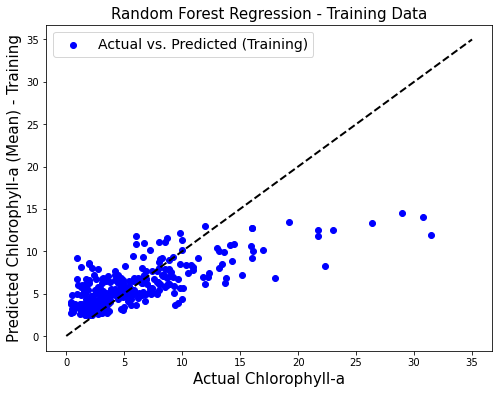

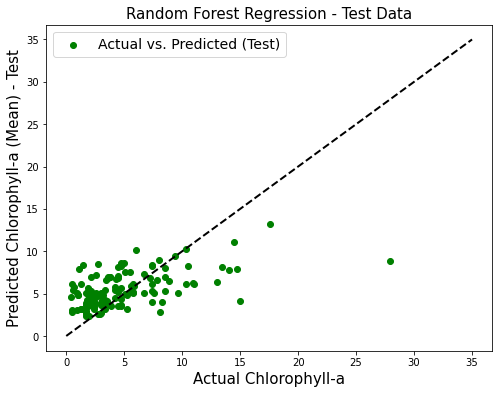

In [22]:
# Number of iterations (J) for the Improved Random Forest
J = 100  # You can adjust the number of iterations as needed

# Lists to store individual decision tree models
decision_trees_mean = []

# Step 2: Training J Decision Trees
for j in range(J):
    # Create a bootstrap sample Dj of size N from the training data
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    # Train the decision model (Random Forest Regressor) using Dj as the training data
    rf_model = RandomForestRegressor(random_state=42, n_estimators=1, max_depth=4, min_samples_split=6, min_samples_leaf=7)
    rf_model.fit(X_train_bootstrap, y_train_bootstrap)

    # Append the trained decision tree to the respective list
    decision_trees_mean.append(rf_model)  # For mean wind pressure coefficient

# Step 3: Predictions and Combining Decision Trees
def combine_decision_trees(predictions):
    return np.mean(predictions, axis=0)

# Predictions
predictions_mean_train = [tree.predict(X_train) for tree in decision_trees_mean]
combined_predictions_mean_train = combine_decision_trees(predictions_mean_train)

predictions_mean_test = [tree.predict(X_test) for tree in decision_trees_mean]
combined_predictions_mean_test = combine_decision_trees(predictions_mean_test)

# Step 4: Evaluate the Model
# Calculate performance metrics for the current iteration
r2_mean_train = r2_score(y_train, combined_predictions_mean_train)
r2_mean_test = r2_score(y_test, combined_predictions_mean_test)
mse_mean_train = mean_squared_error(y_train, combined_predictions_mean_train)
mse_mean_test = mean_squared_error(y_test, combined_predictions_mean_test)
rmse_mean_train = np.sqrt(mse_mean_train)
rmse_mean_test = np.sqrt(mse_mean_test)
mae_mean_train = mean_absolute_error(y_train, combined_predictions_mean_train)
mae_mean_test = mean_absolute_error(y_test, combined_predictions_mean_test)

# Calculate PBIAS (Percent Bias)
pbias_train = ((y_train - combined_predictions_mean_train) / y_train).mean() * 100
pbias_test = ((y_test - combined_predictions_mean_test) / y_test).mean() * 100

print(r2_mean_train)
print(mse_mean_train)
print(rmse_mean_train)
print(mae_mean_train)
print(pbias_train)

print(r2_mean_test)
print(mse_mean_test)
print(rmse_mean_test)
print(mae_mean_test)
print(pbias_test)

# Plot the results for training data
plt.figure(figsize=(8, 6))
plt.scatter(y_train, combined_predictions_mean_train, c='blue', label='Actual vs. Predicted (Training)')
plt.plot([0, 35], [0, 35], 'k--', lw=2)
plt.xlabel('Actual Chlorophyll-a', fontsize=15)
plt.ylabel('Predicted Chlorophyll-a (Mean) - Training', fontsize=15)
plt.title ('Random Forest Regression - Training Data', fontsize=15)
plt.legend(fontsize=14)
plt.show()

# Plot the results for test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, combined_predictions_mean_test, c='green', label='Actual vs. Predicted (Test)')
plt.plot([0, 35], [0, 35], 'k--', lw=2)
plt.xlabel('Actual Chlorophyll-a', fontsize=15)
plt.ylabel('Predicted Chlorophyll-a (Mean) - Test', fontsize=15)
plt.title ('Random Forest Regression - Test Data', fontsize=15)
plt.legend(fontsize=14)
plt.show()